## 1.	Pour chacun des ETF, vous fournissez les statistiques de base
a. Rendement moyen, volatilité, quantile, etc.  
b. L’analyse peut être présentée sous forme de tableaux et graphiques

In [ ]:
#jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=9090 --no-browser
!pip install yfinance
!pip install TA-Lib
!pip install scikit-learn
!pip install pandas-datareader

import yfinance as yf 
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import math as mt
import warnings
import talib
import pylab
import sklearn.linear_model as sk
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from pandas_datareader import data, wb

warnings.filterwarnings('ignore')

start_sp = datetime.datetime(2020,1,1)
end_sp = datetime.datetime(2020,4,1)

BLack_ETF=['IVV','IWF','IJH','IJR','IWM','IWD','ITOT','IVW','IWB','IWR','DVY',
           'IVE','IWP','IWS','IWV','IUSG','IWO','IWN','IBB','IJK','IUSV',
           'OEF','IJS','IJJ','IYW','IHI','IJT','ITA','IGV','IYH','SOXX','EWC',
           'IGM','IYF','JKE','SUSA','IDU','IYY','IYG','JKD','IYC','IYJ','JKG',
           'IWC','IYK','JKF','JKH','IYT','JKI','IYZ','IGE','IYE','JKL','IYM',
           'JKJ','JKK','IGN']

BLack_ETF_sansIVW = ['IVV','IWF','IJH','IJR','IWM','IWD','ITOT','IWB','IWR','DVY',
           'IVE','IWP','IWS','IWV','IUSG','IWO','IWN','IBB','IJK','IUSV',
           'OEF','IJS','IJJ','IYW','IHI','IJT','ITA','IGV','IYH','SOXX','EWC',
           'IGM','IYF','JKE','SUSA','IDU','IYY','IYG','JKD','IYC','IYJ','JKG',
           'IWC','IYK','JKF','JKH','IYT','JKI','IYZ','IGE','IYE','JKL','IYM',
           'JKJ','JKK','IGN']
           

## 2. Par la suite, validez la performance des 5 indicateurs techniques appliqués sur chaque ETF

> a. Calculez la performance du signal (Long, Neutral, Short)

> b. Fournissez les statistiques sur la performance de la classification

In [ ]:
def get_Data_bin(ticker,debut,fin):
    Data = yf.download(ticker, start=debut, end=fin,group_by="ticker")
    rendement = pd.DataFrame(index=Data.index)
    rendement['0'] = (Data['Close']-Data['Open'])/Data['Open']*100
    rendement_bi = pd.DataFrame(np.where(rendement['0'].shift(-1) > rendement['0'], 1, 0), index = rendement.index)
    return rendement_bi, Data, rendement['0']

def data_preprocessing(ticker, Data):
    dataset = pd.DataFrame(index = Data.index)
    dataset['H-L'] = Data['High'] - Data['Low']
    dataset['C-O'] = Data['Close'] - Data['Open']
    
    dataset['ma_5'] = Data['Close'].rolling(window=5).mean()
    dataset['ma_10'] = Data['Close'].rolling(window=10).mean()
    
    dataset['EWMA_12'] = Data['Close'].ewm(span=12).mean()

    dataset['std_5'] = Data['Close'].rolling(window=5).std()
    dataset['std_10'] = Data['Close'].rolling(window=10).std()
    
    dataset['Williams %R'] = talib.WILLR(Data['High'].values, Data['Low'].values, Data['Close'].values, 7)

    #MFI
    dataset['MFI'] = talib.MFI(Data['High'], Data['Low'], Data['Close'], Data['Volume'], timeperiod=14)

    #RSI
    dataset['RSI'] = talib.RSI(Data['Close'], timeperiod = 14)

    #MACD
    macd, dataset['MACD'], macdhist = talib.MACD(Data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

    #STOCHASTIC  
    dataset['STO_k'], dataset['STO_d'] = talib.STOCH(Data['High'], Data['Low'], Data['Close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    
    #BBANDS
    dataset['BBANDS_UP'], centre, dataset['BBANDS_DOWN'] = talib.BBANDS(Data['Close'],timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)                                                                    
    
    #ADX
    dataset['ADX'] = talib.ADX(Data['High'], Data['Low'], Data['Close'], timeperiod=14)
    
    #SMA
    dataset['SMA'] = talib.SMA(Data['Close'], timeperiod=30)
    
    #SAR
    dataset['SAR'] = talib.SAR(np.array(Data['High']), np.array(Data['Low']), 0.2, 0.2)
    
    return dataset

def getXY(etf_trouve,debut,fin):
    X=pd.DataFrame()
    Y=pd.DataFrame()
    for etf in etf_trouve:
        Y_bin, Data, rendement_ticker = get_Data_bin(etf,debut,fin)
        dataset_ini = data_preprocessing(etf, Data)
        X = pd.concat([X,dataset_ini])
        Y = pd.concat([Y,Y_bin])
    X['Y'] = Y
    X = X.dropna()
    Y1 = X['Y']
    X1 = X.drop(columns = ['Y'])
    X2 = pd.DataFrame(preprocessing.scale(X1), columns=X1.columns, index=X1.index)
    #La matrice doit être décalée afin de prédire le jour suivant
    X = X2.iloc[0:-1,:]
    Y = Y1.iloc[1:]
    rendement_ticker = rendement_ticker.loc[Y.index]
    return X,Y, rendement_ticker

X,Y,rend = getXY(BLack_ETF,start_sp,end_sp)

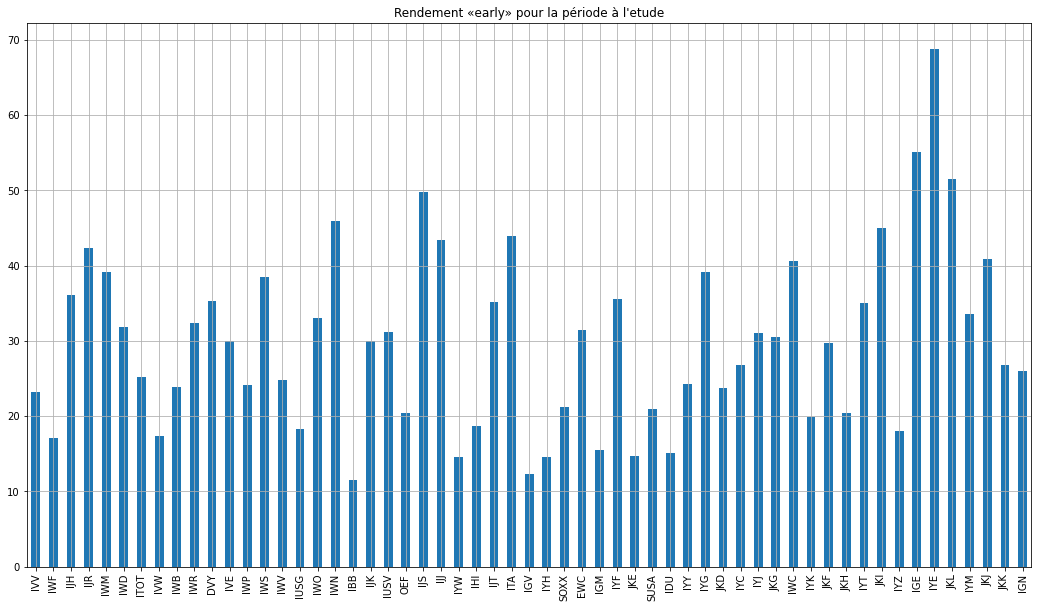

In [ ]:
df = pd.DataFrame([data.DataReader(etf, 'yahoo', start_sp, end_sp)['Adj Close'] for etf in BLack_ETF]).T
df.columns = BLack_ETF
rendement = df.pct_change()
somme = rendement.sum()*-100
somme.plot(kind='bar', grid=True, title = "Rendement «early» pour la période à l'etude",figsize=(18, 10))

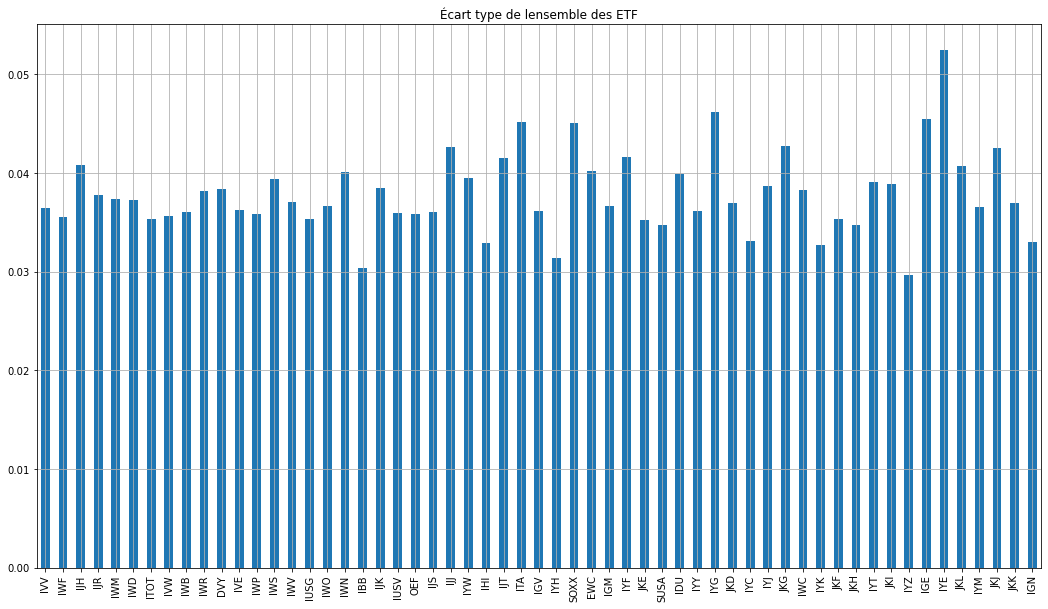

In [ ]:
ecart_type=rendement.std()
ecart_type.plot(kind='bar', grid=True, title = 'Écart type de lensemble des ETF', figsize=(18, 10))

## 3.	Développez un modèle qui combine l’ensemble des indicateurs techniques.

> a.	En premier lieu, construisez un modèle unique pour tous les ETF. Ainsi, vous regroupez l’information sur les 50 ETF dans une seul fichier.

> b.	Utilise 5 types de modèles de classification


> c. Fournissez les statistiques sur la performance de la classification (MC, ROC, AIC)



## 4.	Vous séparez votre échantillon en deux portions

> a.	Échantillon d’entraînement (70% du total)


> b.	Échantillon de test (30% du total)








## 5. Évaluez la capacité de classification.

> i.	Pour l’échantillon d’entraînement et l’échantillon test.

> ii.	Présentez la matrice de confusion et le graphique ROC.

> iii.	Interprétez les résultats.

> iv.	Quelles sont les variables les plus importantes dans ce modèle?










1) Modele Logit

In [ ]:
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, confusion_matrix

def calcul_aic(n, mse, num_param):
    aic = n * mt.log(mse) + 2 * num_param
    return aic

def calculModelLogit(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 0)
    ModeleLogit = sk.LogisticRegression()
    TrainFit = ModeleLogit.fit(trainX, trainY)
    TrainScores = ModeleLogit.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleLogit.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleLogit.predict(testX)
    proba = ModeleLogit.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calcul_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, ModeleLogit.coef_, testY, ModeleLogit, proba, trainY, trainX



def getROC(yTest, prediction, proba):
    fpr, tpr, thres = roc_curve(yTest, proba)
    ac = roc_auc_score(yTest, prediction)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkgreen', lw=lw, label='ROC curve (area = %0.2f)' % ac)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Faux Positif')
    plt.ylabel('Vrai Positif')
    plt.title('Exemple de caractéristique de fonctionnement du récepteur')
    plt.legend(loc="lower right")
    plt.show()


def getMC(yTest, prediction):
    matrice = confusion_matrix(yTest, prediction)
    print(matrice) 

In [ ]:
predictions, TrainScores, TestsScorelogit, aic, coefficientModel, testY, model, proba, trainY, trainX = calculModelLogit(X, Y)

Train score= 0.6833910034602076
Test score= 0.6995967741935484
AIC score : -560.5042919066162


D'abord, l'échantillon d'entrainement

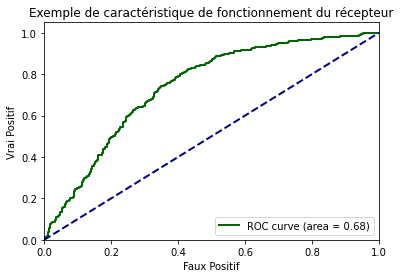

In [ ]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [ ]:
getMC(trainY, model.predict(trainX))

[[397 193]
 [173 393]]


Ensuite pour l'échantillon test

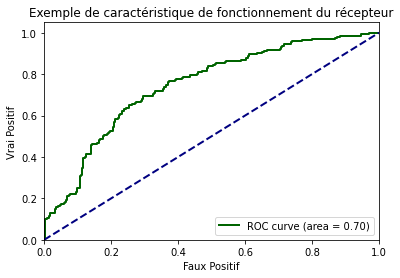

In [ ]:
getROC(testY, predictions, proba)

In [ ]:
getMC(testY, predictions)

[[193  81]
 [ 68 154]]


In [ ]:
variableImportanteB = pd.DataFrame(coefficientModel, columns=X.columns).T
varB = variableImportanteB.sort_values(by=0,ascending = False)
varB

,0
SMA,1.349694
SAR,1.173388
ma_10,0.617840
C-O,0.577979
EWMA_12,0.562632
RSI,0.516436
Williams %R,0.076617
MFI,-0.012338
std_5,-0.069654
ADX,-0.116598


Dans le but d'obtenir une classification plus optimale, les paramètres non significatifs ne seront pas sélectionnés pour la suite de l'analyse.

In [ ]:
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
from sklearn.feature_selection import RFE
feature_list = list(X.columns)
rfe = RFE(model,8)
rfe = rfe.fit(X, Y)
print(rfe.support_)
print(rfe.ranking_)
rapport = rfe.support_

nouvelleBD = X
## On souhaite visualiser les variables qui ne sont pas significatives
for i in range(0,len(rapport)):
    if rapport[i]==False :
        sigle = X
        print("Le paramètre",feature_list[i], "n'a pas été selectionné")
        nouvelleBD = nouvelleBD.drop(columns = feature_list[i])

[False False  True False  True False False False False  True False False
  True  True  True False  True  True]
[ 4  3  1  5  1 10  2  8 11  1  7  6  1  1  1  9  1  1]
Le paramètre H-L n'a pas été selectionné
Le paramètre C-O n'a pas été selectionné
Le paramètre ma_10 n'a pas été selectionné
Le paramètre std_5 n'a pas été selectionné
Le paramètre std_10 n'a pas été selectionné
Le paramètre Williams %R n'a pas été selectionné
Le paramètre MFI n'a pas été selectionné
Le paramètre MACD n'a pas été selectionné
Le paramètre STO_k n'a pas été selectionné
Le paramètre ADX n'a pas été selectionné


On refait maintenant l'analyse à partir des paramètres significatifs 

In [ ]:
predictions, TrainScores, TestsScorelogit, aic, coefficientModel, testY, model, proba, trainY, trainX = calculModelLogit(nouvelleBD, Y)

Train score= 0.6012110726643599
Test score= 0.6108870967741935
AIC score : -452.1673259587408


Voici les nouveaux résultats obtenus: 

    Train score= 0.6937716262975778

    Test score= 0.6995967741935484

    AIC score : -580.5042919066162


De retour à l'echantillon d'entrainement

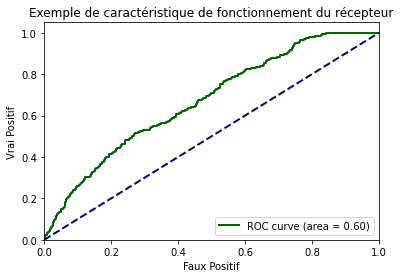

In [ ]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [ ]:
getMC(trainY, model.predict(trainX))

[[343 247]
 [214 352]]


Puis à l'échantillon test

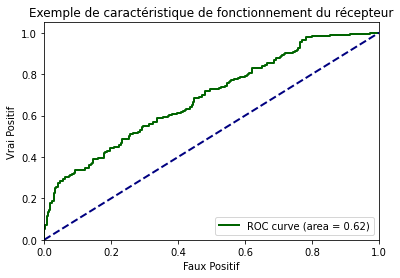

In [ ]:
getROC(testY, predictions, proba)

In [ ]:
getMC(testY, predictions)

[[151 123]
 [ 70 152]]


In [ ]:
coefficientModel

array([[-0.56431507,  0.27363074,  0.7379253 , -0.90370718, -1.36663226,
         0.33041259,  0.24535886,  1.05593838]])

Interprétation des résultats :  Le % du test est de 69,9% ce qui est supérieur à la valeur de 68,3% obtenue à l'étape précédente. D'un autre côté, en effectuant la méthode de l'élimination récursive,  on remarque que l'AIC a montré un résultat inférieur. Cependant, l'accuracy est resté semblable.  


2) Arbre de décision

In [ ]:
from sklearn import tree

def calculModeleArbreDecision(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 0)
    ModeleArbreD = tree.DecisionTreeClassifier()
    
    TrainFit = ModeleArbreD.fit(trainX, trainY)
    
    TrainScores = ModeleArbreD.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleArbreD.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleArbreD.predict(testX)
    
    proba = ModeleArbreD.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calcul_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, testY, testX, proba, trainY, trainX, ModeleArbreD

In [ ]:
predictions, TrainScores, TestsScoretree, aic, testY, testX, prob, trainY, trainX, model = calculModeleArbreDecision(X, Y)

Train score= 1.0
Test score= 0.7923387096774194
AIC score : -743.6360814936646


D'abord l'échantillon d'entrainement

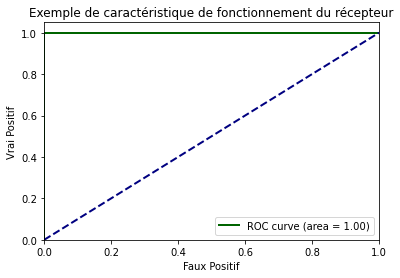

In [ ]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [ ]:
getMC(trainY, model.predict(trainX))

[[590   0]
 [  0 566]]


Ensuite, l'échantillon test

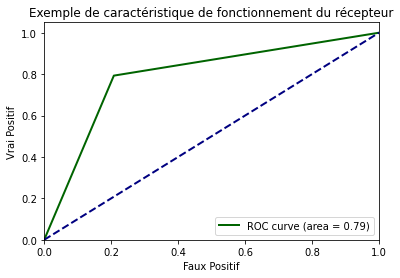

In [ ]:
getROC(testY, predictions, prob)

In [ ]:
getMC(testY, predictions)

[[217  57]
 [ 46 176]]


Nous avons maintenant éliminé les variables non significatives identifiées lors du test logit afin d'obtenir une classification optimale.


In [ ]:
nouvellePredictions, nouveauTrainScores, nouveauTestsScore, nouveauAIC, nouveautestY, nouveautestX, prob, nouveauTrainY, nouveautrainX, nouveauModel = calculModeleArbreDecision(nouvelleBD, Y)

Train score= 1.0
Test score= 0.6129032258064516
AIC score : -454.74395512978435


De retour à l'échantillon d'entrainement

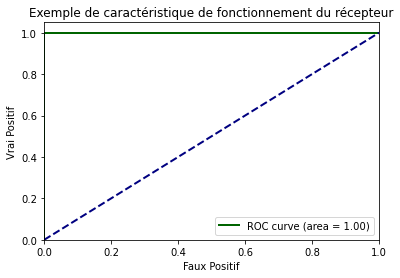

In [ ]:
getROC(nouveauTrainY, nouveauModel.predict(nouveautrainX), nouveauModel.predict_proba(nouveautrainX)[:,1])

In [ ]:
getMC(nouveauTrainY, nouveauModel.predict(nouveautrainX))

[[590   0]
 [  0 566]]


Puis à l'échantillon test

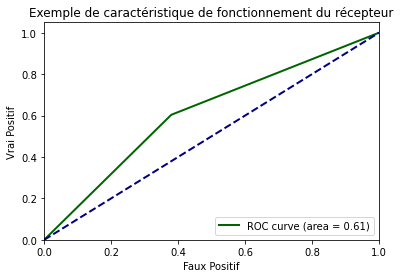

In [ ]:
getROC(nouveautestY, nouvellePredictions, prob)

Interprétation des résultats: On observe une légère diminution de la précision du test passant de 78,4% à 73,7%

3) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def calculModelRandomForest(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 42)
    ModeleRF = RandomForestClassifier()
    
    TrainFit = ModeleRF.fit(trainX, trainY)
    
    TrainScores = ModeleRF.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleRF.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleRF.predict(testX)
    
    proba = ModeleRF.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calcul_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    variableImportante = ModeleRF.feature_importances_
    return predictions, TrainScores, TestsScore, aic, testY, variableImportante, proba, trainY, trainX, ModeleRF

In [ ]:
predictions, TrainScores, TestsScoreforest, AIC, testY, variableImportante, prob, trainY, trainX, modelRF = calculModelRandomForest(X, Y)

Train score= 1.0
Test score= 0.8528225806451613
AIC score : -914.393776845962


D'abord l'échantillon d'entrainement

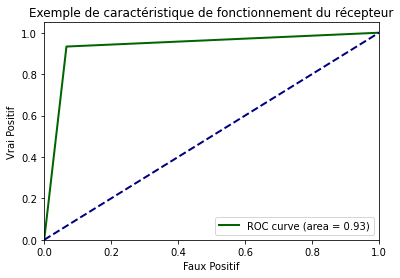

In [ ]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [ ]:
getMC(trainY, model.predict(trainX))

[[576  41]
 [ 36 503]]


Puis l'échantillon test

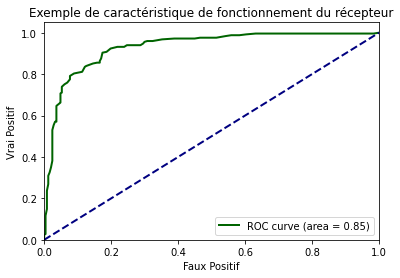

In [ ]:
getROC(testY, predictions, prob)

In [ ]:
getMC(testY, predictions)

[[222  25]
 [ 48 201]]


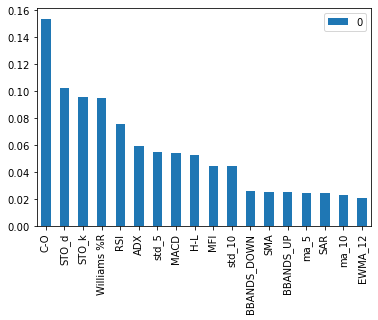

In [ ]:
variableImportanteA = pd.DataFrame(variableImportante, index=X.columns)
variableImportanteA.sort_values(by=0,ascending = False).plot(kind='bar')

Les variables significatives obtenues par le modèle Logit sont :
- O-C
- MACD
- SMA
- EWMA_12
- STO_k

Les variables significatives obtenues par le modèle Random Forest sont :
- O-C
- Williams %R
- Stochastique_k
- RSI
- Stochastique_d

La variation des résultats obtenus par ces deux modèles est principalement expliquée par le fait que le modèle Logit utilise des données à faible variation en opposition au modèle Random Forest qui sélectionne des données dont la variabilité est plus élevée. 


4) Support Vector Machine: Linear and Radial classification

In [ ]:
from sklearn.svm import SVC 
def calculModeleSVM(X,Y,typ):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 42)
    ModeleSVM = SVC(kernel=typ)
    
    TrainFit = ModeleSVM.fit(trainX, trainY)
    
    TrainScores = ModeleSVM.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleSVM.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleSVM.predict(testX)
    
    mse = mean_squared_error(testY, predictions)
    aic = calcul_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, testY, trainY, trainX, ModeleSVM

Débutons par l'échantillon d'entrainement

In [ ]:
predictions, TrainScores, TestsScorelin, aic, testY, trainY, trainX, ModeleSVM = calculModeleSVM(X,Y,'linear')

Train score= 0.6877162629757786
Test score= 0.7096774193548387
AIC score : -577.4342630658676


In [ ]:
getMC(testY, predictions)

[[184  63]
 [ 81 168]]


Puis l'échantillon test

In [ ]:
predictions, TrainScores, TestsScoreradial, aic, testY, trainY, trainX, model = calculModeleSVM(X,Y,'rbf')

Train score= 0.8235294117647058
Test score= 0.7903225806451613
AIC score : -738.8437736814432


In [ ]:
getMC(testY, predictions)

[[200  47]
 [ 57 192]]


On observe que le % d'accuracy a tendance à augmenter avec la fonction radiale par rapport à la fonction linéaire. D'ailleurs l,AIC est nettement plus faible avec la fonction radiale.


6. Comparez une dernière fois, l’ensemble des modèles, sélectionnez-en un et expliquez votre choix.



In [ ]:
accuracy = pd.DataFrame([TestsScorelogit,TestsScoreforest,TestsScoretree, TestsScoreradial,TestsScorelin],
                       index = ['Modèle Logit','Modèle Forest','Decision Tree','Radial','Linéaire'], columns = ['% des tests'])*100
accuracy

,% des tests
Modèle Logit,61.088710
Modèle Forest,85.282258
Decision Tree,79.233871
Radial,79.032258
Linéaire,70.967742


À la lumière des résultats obtenus, le modèle le plus précis est le modèle Random Forest: à 85,28%.

Il fait répond à toutes les possibilités testées ce qui rend son modele plus précis dans ce cas.


10.	Répétez l’exercice mais cette fois-ci pour chaque ETF pris individuellement.

> a.	Refaites l’exercice précédent, mais pour chaque échantillon.

> b.	Assurez vous d’avoir le même échantillon

> c.	Comparez la performance d’une estimation individuelle vs modèle regroupé de l’étape précédente.

> d.	Pas besoin de présenter tous les résultats mais uniquement la performance soit le rendement du modèle agrégé vs modèles individuels.




In [ ]:
modele_unique = pd.DataFrame(index = BLack_ETF)
testscore=[]
AIC = []
for etf in BLack_ETF:
    X,Y,rend = getXY([etf],start_sp,end_sp)
    predictions, TrainScores, TestsScoreforest, aic, testY, variableImportante, prob, trainY, trainX, model = calculModelRandomForest(X, Y)
    testscore.append(TestsScoreforest)
    AIC.append(aic)
modele_unique['% au test']=testscore
modele_unique['AIC']=AIC

[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.3333333333333333
AIC score : 32.35081402702652
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.3333333333333333
AIC score : 32.35081402702652
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.3333333333333333
AIC score : 32.35081402702652
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.4444444444444444
AIC score : 30.70992001588093
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.1111111111111111
AIC score : 34.93995267909255
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.2222222222222222
AIC score : 33.73817014547185
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.2222222222222222
A

In [ ]:
modele_unique

,% au test,AIC
IVV,0.333333,32.350814
IWF,0.333333,32.350814
IJH,0.333333,32.350814
IJR,0.444444,30.709920
IWM,0.111111,34.939953
IWD,0.222222,33.738170
ITOT,0.222222,33.738170
IVW,0.333333,32.350814
IWB,0.111111,34.939953
IWR,0.222222,33.738170


In [ ]:
modele_unique.mean(axis=0)

% au test     0.309942
AIC          32.474016
dtype: float64

c.	Comparez la performance d’une estimation individuelle vs modèle regroupé de l’étape précédente.

En utilisant un modele qui évalue la performance individuelle d'un ETF, on remarque que les résultats obtenus sont plus difficiles à employer afin d'expliquer la performance des autres ETF à l'aide d'un seul modèle. Ainsi, afin d'arriver à bien évaluer un stock, il serait pertinent de créer un modèle différent à chaque fois. 
D'un autre côté, l'accuracy obtenue est inférieur pour l'estimation individuelle vs le modèle regroupé.

Source :
https://github.com/mrjbq7/ta-lib
https://medium.com/@rbhatia46/using-svm-on-top-of-technical-indicators-to-predict-reliance-stock-prices-abb494d9f45f


11.	Enfin, si vous voulez pousser encore plus loin (optionnel)


a.	Développez un modèle de trading pour l’ETF sur l’indice SP500, soit ‘’IVW’’.
b.	Utilisez comme signal l’ensemble des indicateurs techniques pour l’ensemble des ETF.
c.	Ajouter le rendement de la journée précédente de tous les ETF.
d.	Ajouter également le rendement de la semaine précédentes de tous les ETF.
e.	Utilisez un SVM (radial) ou un deep learning.
f.	Comparez votre performance avec le rendement du SP500, soit une position passive sur l’ETF ‘’IVW’’.
g.	Notez bien que cette section est optionnelle mais pourrait fort bien constituer un projet de session


In [ ]:
def rendementmodele(ticker,debut,fin):
    rendement_total=0
    rendement=0
    rend_graph=[]
    rend_graphique = pd.DataFrame()
    for tick in ticker:
        X, Y, rend = getXY([tick],debut,fin)
        pred = modelRF.score(X,Y)
        prediction = modelRF.predict(X)
        for i in range(len(prediction)-1): 
            if prediction[i]==1:
                rendement = rend[i+1]
            elif prediction[i]==0:
                rendement = -rend[i+1]
            rendement_total += rendement
            rend_graph.append(rendement_total)
        rend_graphique[tick] = np.transpose(rend_graph)
        rend_graph=[]
        rendement_total=0
        rendement=0
    return rendement_total,rend_graphique, rend      

In [ ]:
start_sp_test = datetime.datetime(2017,12,31)
end_sp_test = datetime.datetime(2019,12,31)
rend, rend_graph, rend = rendementmodele(BLack_ETF_sansIVW,start_sp_test,end_sp_test)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

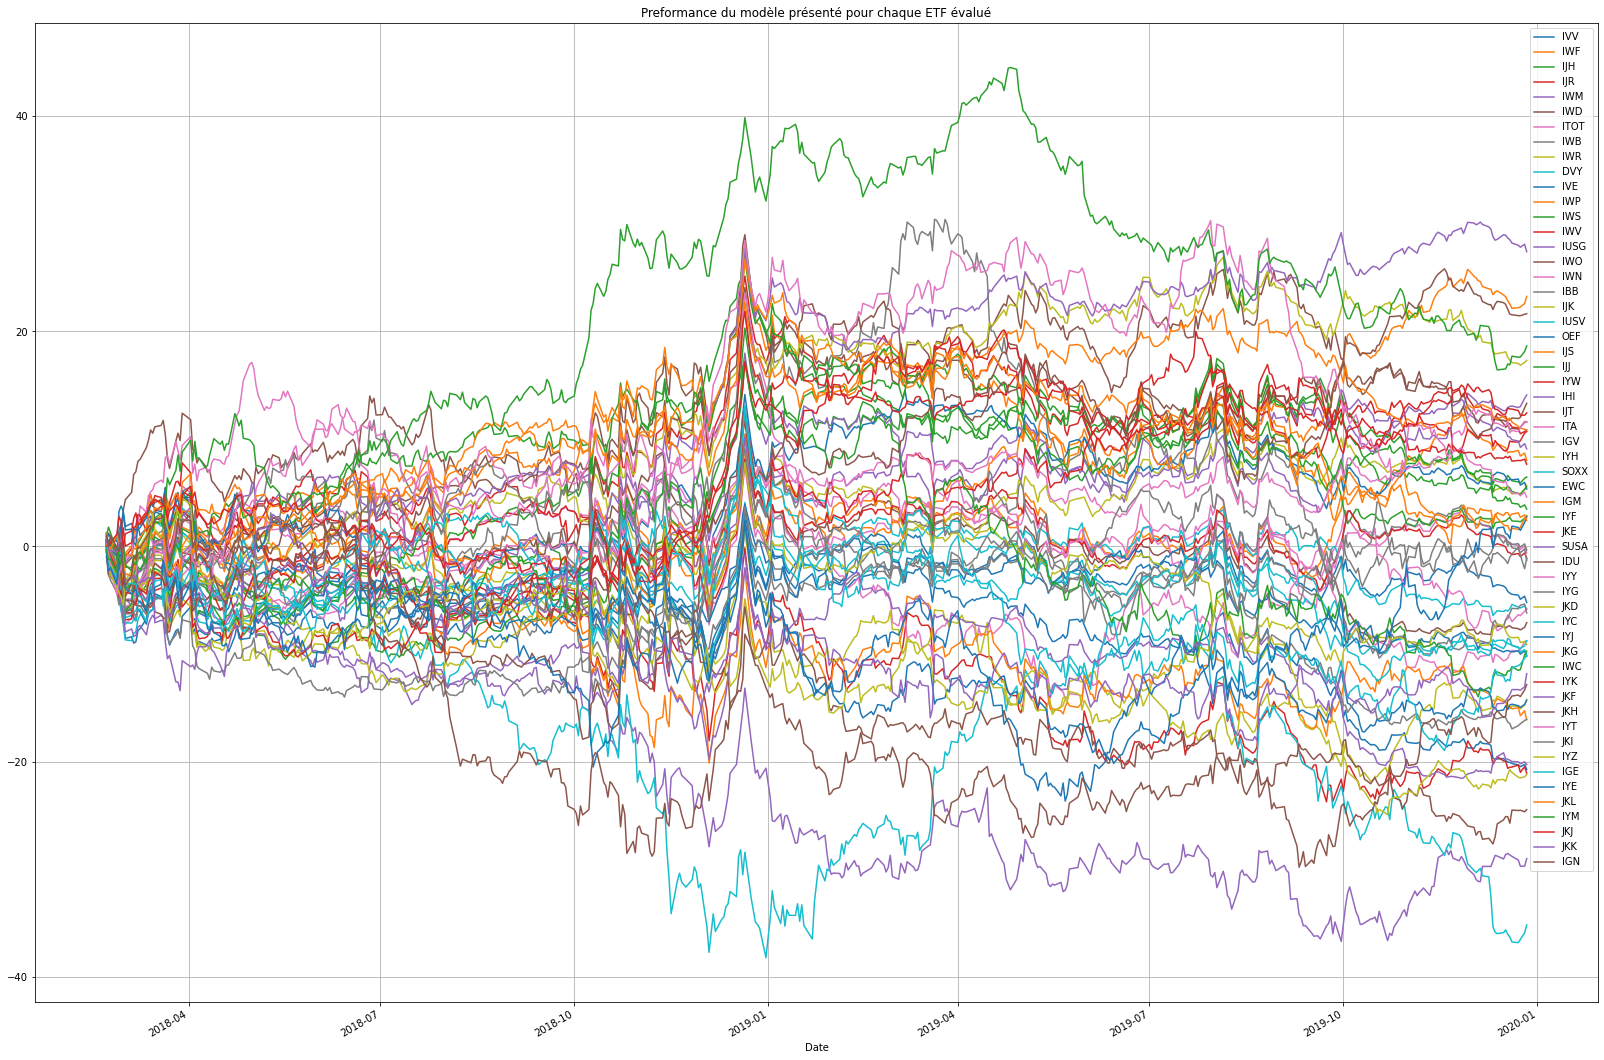

In [ ]:
rend_graph.index = rend.index[0:-1]
rend_graph.plot(grid=True, title = 'Preformance du modèle présenté pour chaque ETF évalué',figsize=(28, 20))

In [ ]:
rendement = pd.DataFrame(rend_graph.mean(axis=1),index=rend.index[0:-1],
                          columns=['La moyenne Black ETF à partir du modèle Random Forest'])

In [ ]:
#IVW
Data = yf.download('IVW', start=start_sp_test, end=end_sp_test,group_by="ticker")
IVW = pd.DataFrame(Data['Close'].pct_change().cumsum()*100,index=rend.index[0:-1])
IVW.columns=['ETF qui imite le SP500']
Figure=pd.concat([rendement, IVW.reindex(rendement.index)], axis=1)

[*********************100%***********************]  1 of 1 completed


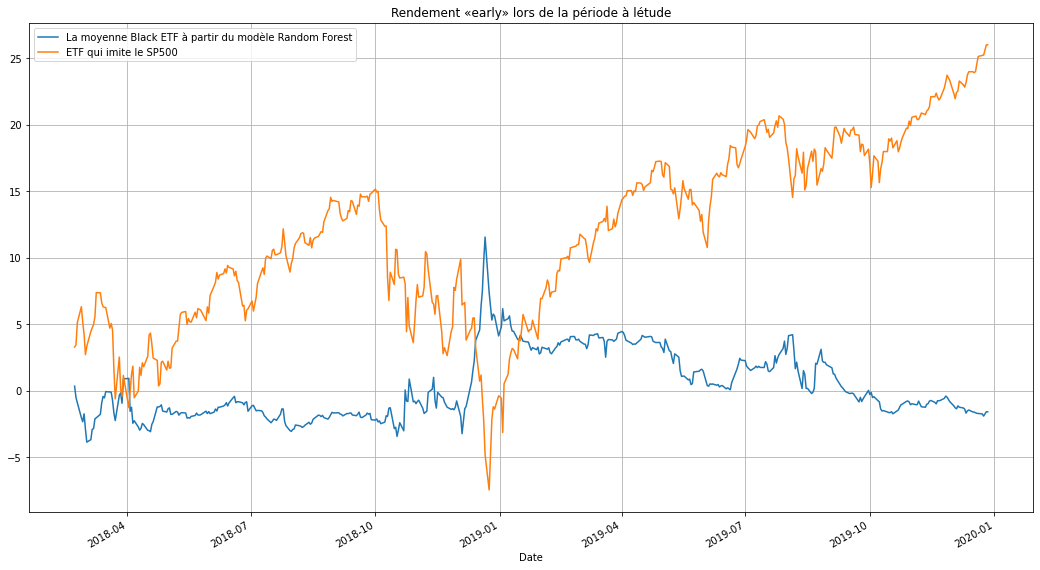

In [ ]:
Figure.plot(grid=True, title = 'Rendement «early» lors de la période à létude',figsize=(18, 10))

Comparaison de la performance vs celle du S&P 500. Tel qu'il est possible de l'observer, nous n'avons pas été en mesure de battre l'indice 